In [6]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import load_excel, load_odin_as_ml_dataset, plot_confusion_matrix, make_ml_dataset, run_binary_regression, transport_modes, trip_motives, province_codes, transport_mode_col

In [22]:
pd.read_excel(odin_excel_path.replace("csv", "xlsx"), )

KeyboardInterrupt: 

In [24]:
years = [2019, 2020, 2021, 2022, 2023]
dfs = []
for year in years:
    odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
    if year in [2019, 2020]:
        odin_excel_path = odin_excel_path.replace("Databestand", "Databestand_v2.0")
    df = load_excel(odin_excel_path)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV


In [25]:
len(df_all), len(df_all["OPID"].unique())

(964633, 309815)

In [26]:
len(df_all) / df_all["VertPC"].unique().shape[0]

240.31714000996513

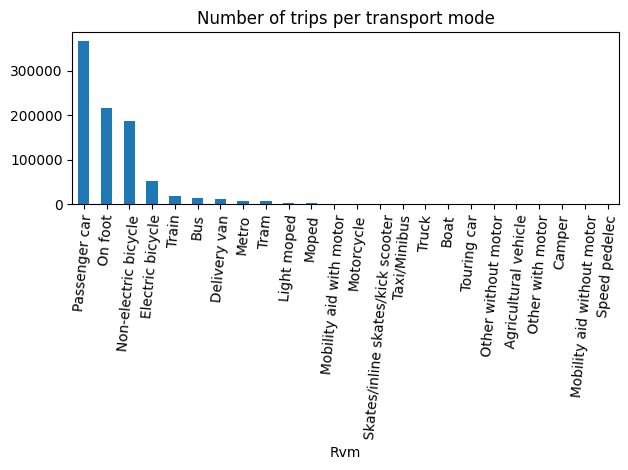

In [30]:
# Create a histogram for the number of trips for each transport mode and translate to 
ax = df_all[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode")

ax.set_xticklabels([transport_modes.get(int(float(label.get_text())), label.get_text()) for label in ax.get_xticklabels()], rotation=85)

plt.tight_layout()
plt.savefig("graphics/transport_modes_histogram.png", dpi=300)
plt.show()

In [5]:
print(transport_modes)

{1: 'Passenger car', 2: 'Train', 3: 'Bus', 4: 'Tram', 5: 'Metro', 6: 'Speed pedelec', 7: 'Electric bicycle', 8: 'Non-electric bicycle', 9: 'On foot', 10: 'Touring car', 11: 'Delivery van', 12: 'Truck', 13: 'Camper', 14: 'Taxi/Minibus', 15: 'Agricultural vehicle', 16: 'Motorcycle', 17: 'Moped', 18: 'Light moped', 19: 'Mobility aid with motor', 20: 'Mobility aid without motor', 21: 'Skates/inline skates/kick scooter', 22: 'Boat', 23: 'Other with motor', 24: 'Other without motor'}


In [6]:
print(trip_motives)

{1: 'Commuting (to and from work)', 2: 'Business visit (at work location)', 3: 'Occupational (work-related)', 4: 'Picking up/dropping off people', 5: 'Picking up/dropping off goods', 6: 'Education/course attendance', 7: 'Shopping/grocery shopping', 8: 'Visiting/staying over', 9: 'Touring/hiking', 10: 'Sports/hobby', 11: 'Other leisure activity', 12: 'Services/personal care', 13: 'Other motive'}


In [7]:
print(province_codes)

{0: 'No departure point in the Netherlands', 1: 'Groningen', 2: 'Friesland', 3: 'Drenthe', 4: 'Overijssel', 5: 'Flevoland', 6: 'Gelderland', 7: 'Utrecht', 8: 'North Holland', 9: 'South Holland', 10: 'Zeeland', 11: 'North Brabant', 12: 'Limburg', 99: 'Unknown'}


In [8]:
df.columns

Index(['OP', 'OPID', 'Steekproef', 'Mode', 'HHPers', 'HHSam', 'HHPlOP',
       'HHLft1', 'HHLft2', 'HHLft3',
       ...
       'RReisduur', 'RReisduurBL', 'RVertStat', 'RAankStat', 'RTSamen',
       'RCorrSnelh', 'RVliegVer', 'FactorH', 'FactorP', 'FactorV'],
      dtype='object', length=247)

Common labels: [False  True]


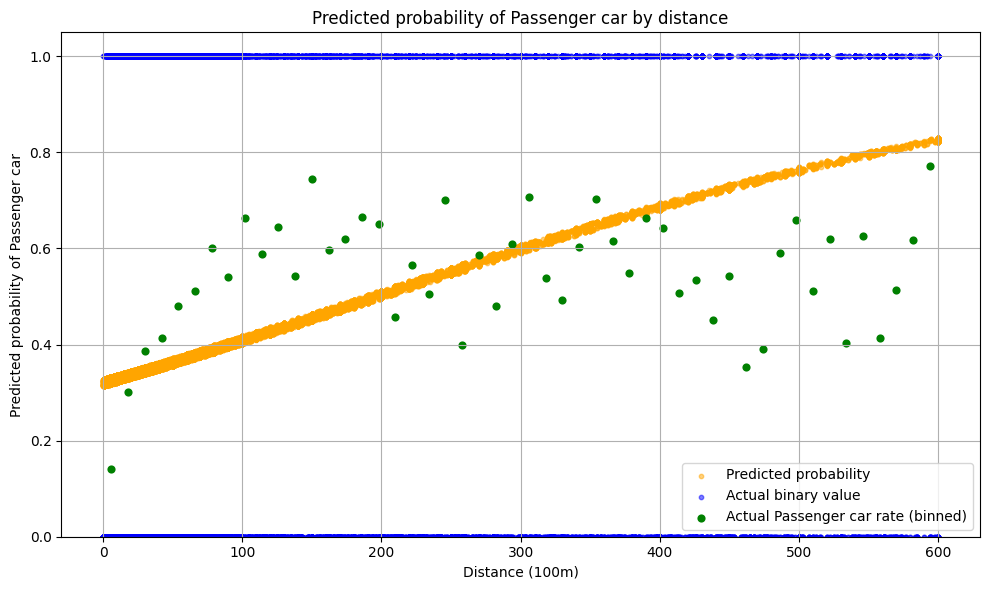

Common labels: [False  True]


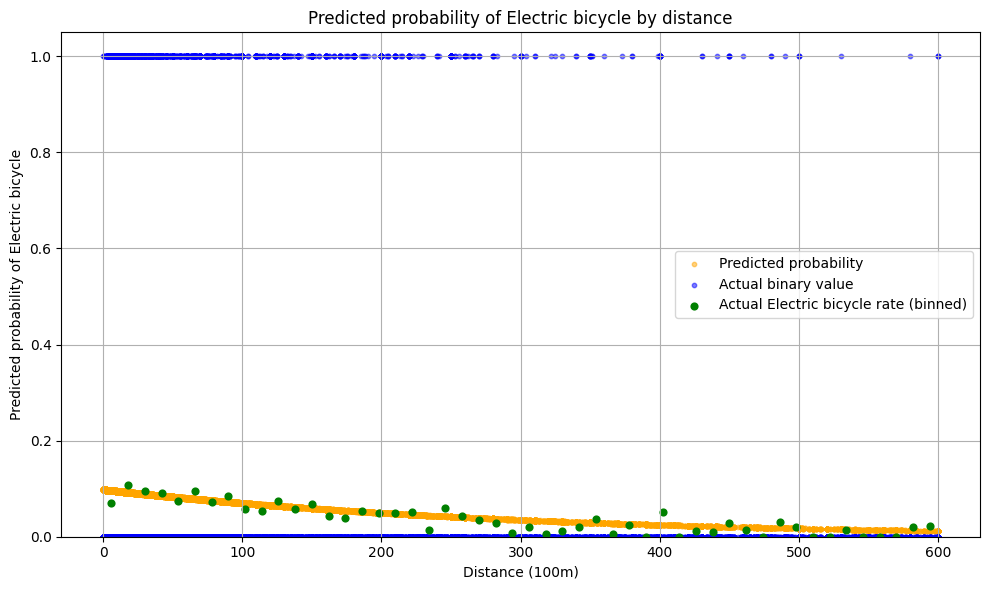

Common labels: [False  True]


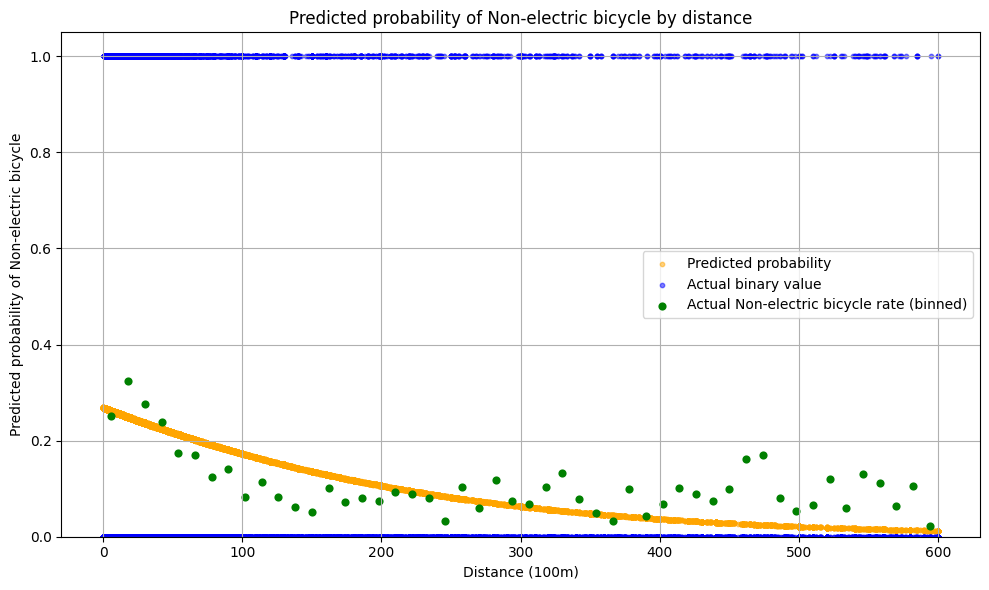

Common labels: [False  True]


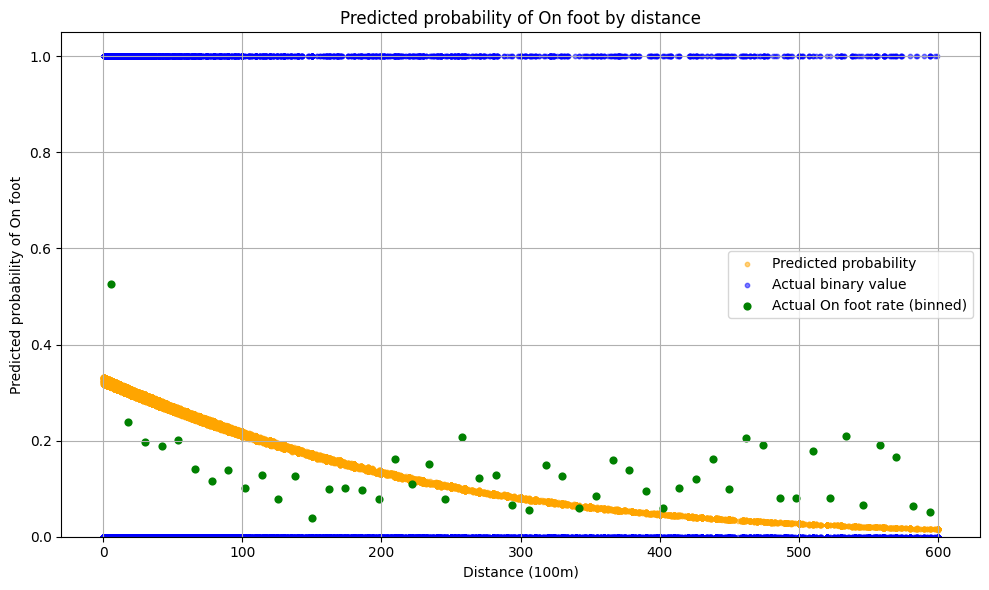

In [31]:
max_dist=600 # max distance in 100s of meters
motives=None 
vehicles_to_include = [1, 7, 8, 9, ]
for transport_mode in vehicles_to_include:
    run_binary_regression(
        df,
        test_size=0.2,
        transport_modes_predict=[transport_mode, ],
        motives=motives,
        max_dist=max_dist,
        savename=f"graphics/classification_results/binary_regression/{motives}/{transport_modes[transport_mode].replace(r'/', ' or ')}_{max_dist}",
    )

Common labels: [False  True]


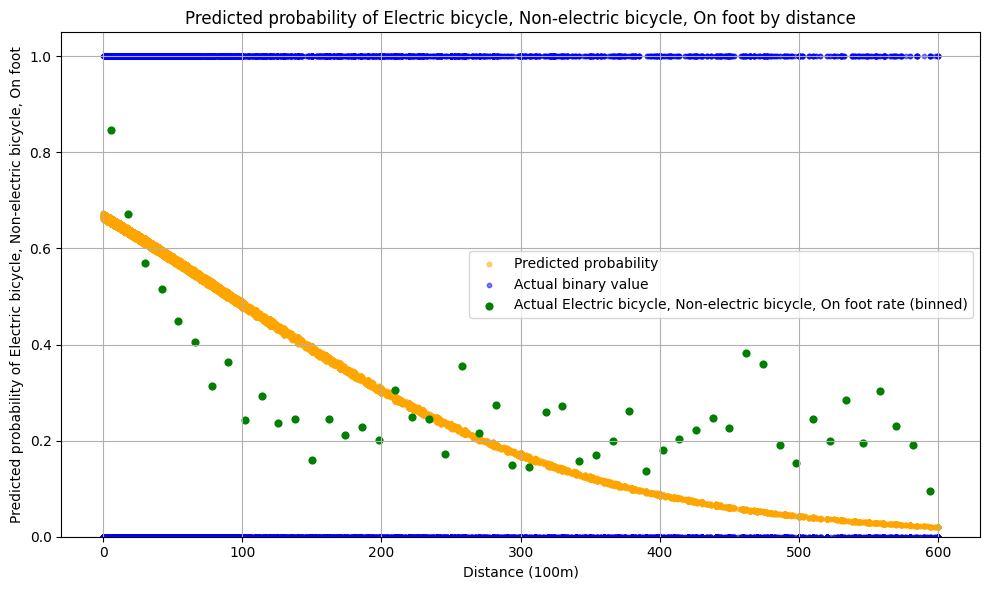

In [32]:
combined_modes = [[7, 8, 9]]
for tm in combined_modes:
    transport_mode_str = ", ".join([transport_modes[tm_] for tm_ in tm])
    run_binary_regression(
        df,
        test_size=0.2,
        transport_modes_predict=tm,
        motives=motives,
        max_dist=max_dist,
        savename=f"graphics/classification_results/binary_regression/{motives}/{transport_mode_str.replace(r'/', ' or ')}_{max_dist}",
    )

Now a classifier that classifies what mode of transport was used

In [11]:
print(transport_modes)

{1: 'Passenger car', 2: 'Train', 3: 'Bus', 4: 'Tram', 5: 'Metro', 6: 'Speed pedelec', 7: 'Electric bicycle', 8: 'Non-electric bicycle', 9: 'On foot', 10: 'Touring car', 11: 'Delivery van', 12: 'Truck', 13: 'Camper', 14: 'Taxi/Minibus', 15: 'Agricultural vehicle', 16: 'Motorcycle', 17: 'Moped', 18: 'Light moped', 19: 'Mobility aid with motor', 20: 'Mobility aid without motor', 21: 'Skates/inline skates/kick scooter', 22: 'Boat', 23: 'Other with motor', 24: 'Other without motor'}


Use all vehicles. Sucks and should not be used

Common labels: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23.]


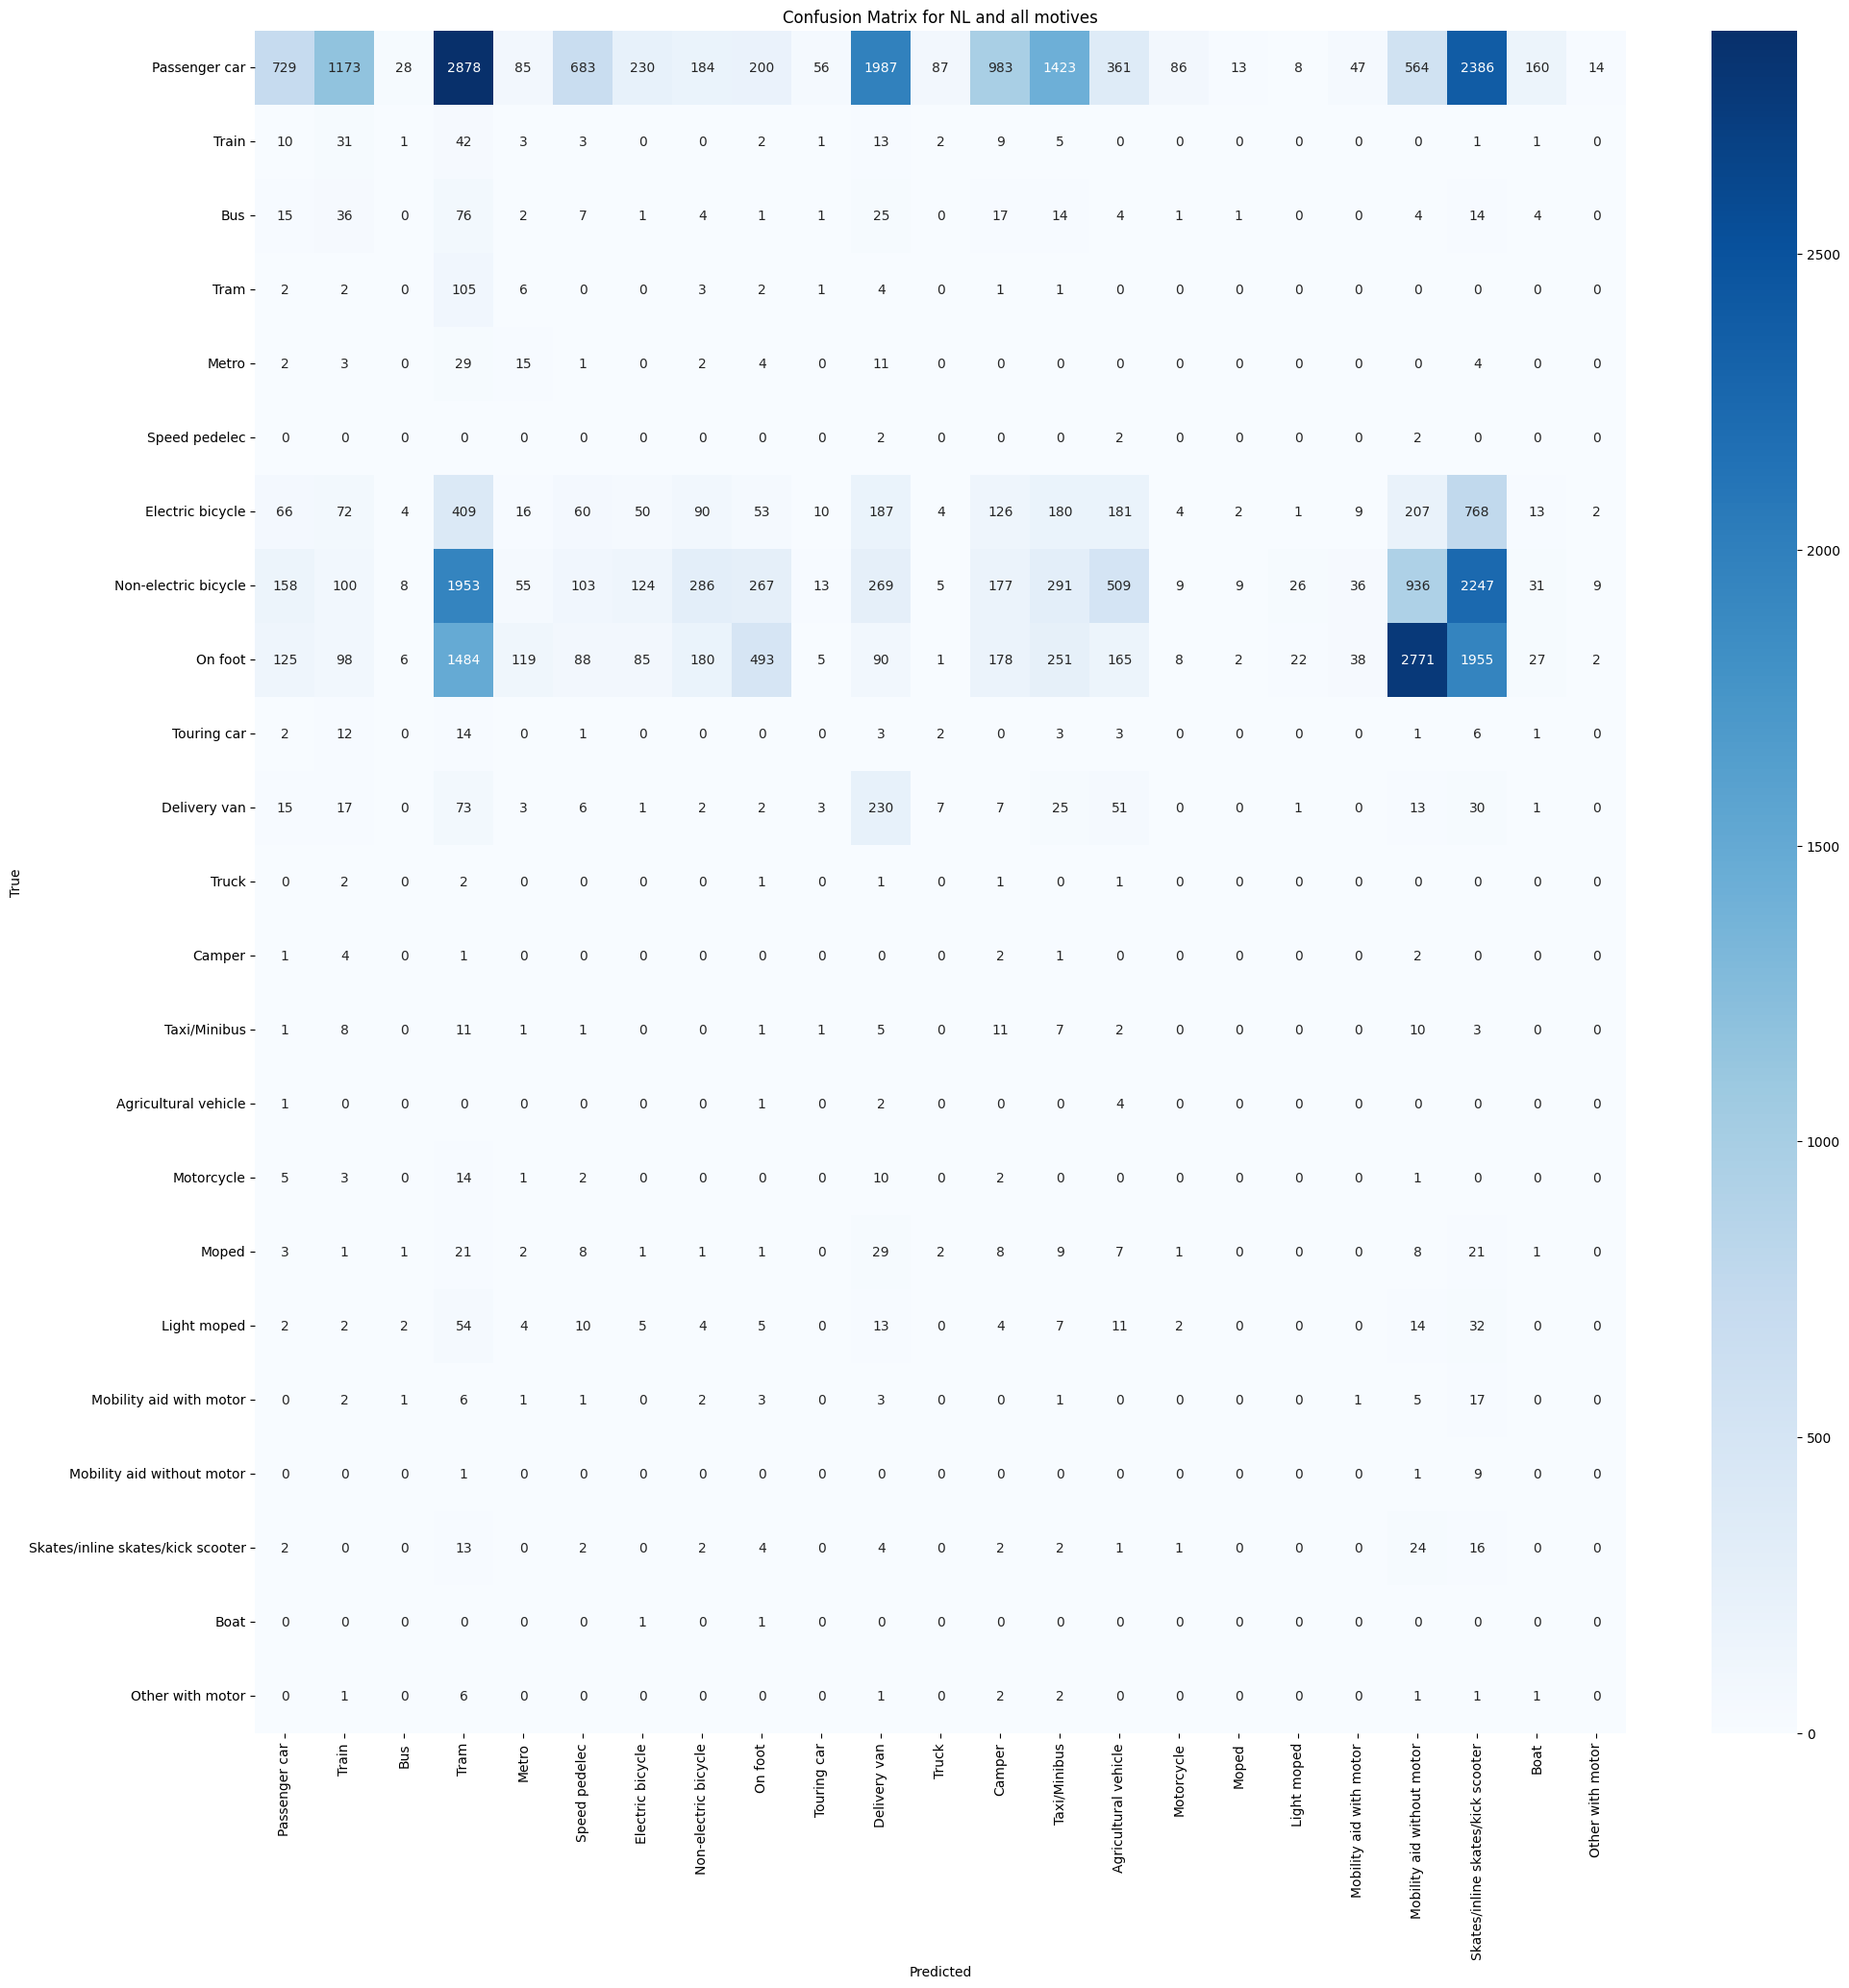

                                   precision    recall  f1-score   support

                    Passenger car       0.64      0.05      0.09     14365
                            Train       0.02      0.25      0.04       124
                              Bus       0.00      0.00      0.00       227
                             Tram       0.01      0.83      0.03       127
                            Metro       0.05      0.21      0.08        71
                    Speed pedelec       0.00      0.00      0.00         6
                 Electric bicycle       0.10      0.02      0.03      2514
             Non-electric bicycle       0.38      0.04      0.07      7621
                          On foot       0.47      0.06      0.11      8193
                      Touring car       0.00      0.00      0.00        48
                     Delivery van       0.08      0.47      0.14       487
                            Truck       0.00      0.00      0.00         8
                        

In [21]:
from codebase import run_multiclass_classification, distance_col, origin_col, province_codes, level_mapping_suffix, age_col, transport_mode_col, motive_col, urbanness_col


df_multiclass = df[df[transport_mode_col] != df[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
categorical_features=[origin_col]
numerical_features=[distance_col, urbanness_col, motive_col]
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

_ = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/{origins}/{motives}/{categorical_features + numerical_features}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

Common labels: [1. 2. 3. 7. 8. 9.]


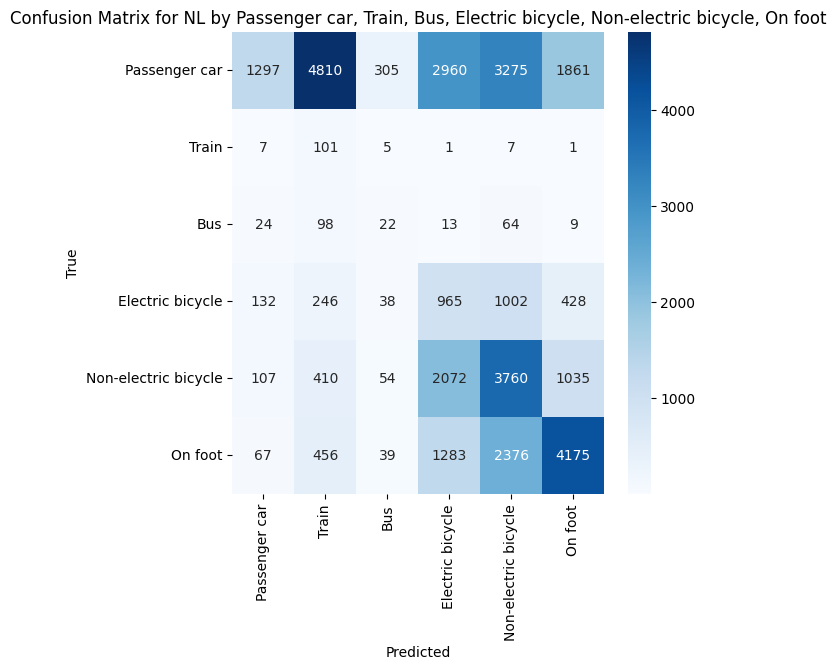

                      precision    recall  f1-score   support

       Passenger car       0.79      0.09      0.16     14508
               Train       0.02      0.83      0.03       122
                 Bus       0.05      0.10      0.06       230
    Electric bicycle       0.13      0.34      0.19      2811
Non-electric bicycle       0.36      0.51      0.42      7438
             On foot       0.56      0.50      0.52      8396

            accuracy                           0.31     33505
           macro avg       0.32      0.39      0.23     33505
        weighted avg       0.57      0.31      0.31     33505



In [20]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

motives=None
origins=None#[7, 8, ]
location_level=2
categorical_features=[origin_col]
numerical_features=[distance_col, urbanness_col, motive_col]
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"

_ = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/{origins}/less_vehicles/age_{age_range[0]}_{age_range[1]}/{categorical_features + numerical_features}",
    plot_title=f"Confusion Matrix for {origin_str} by {', '.join(transport_modes[tm] for tm in vehicles_to_include)}",
)

Common labels: [False  True]


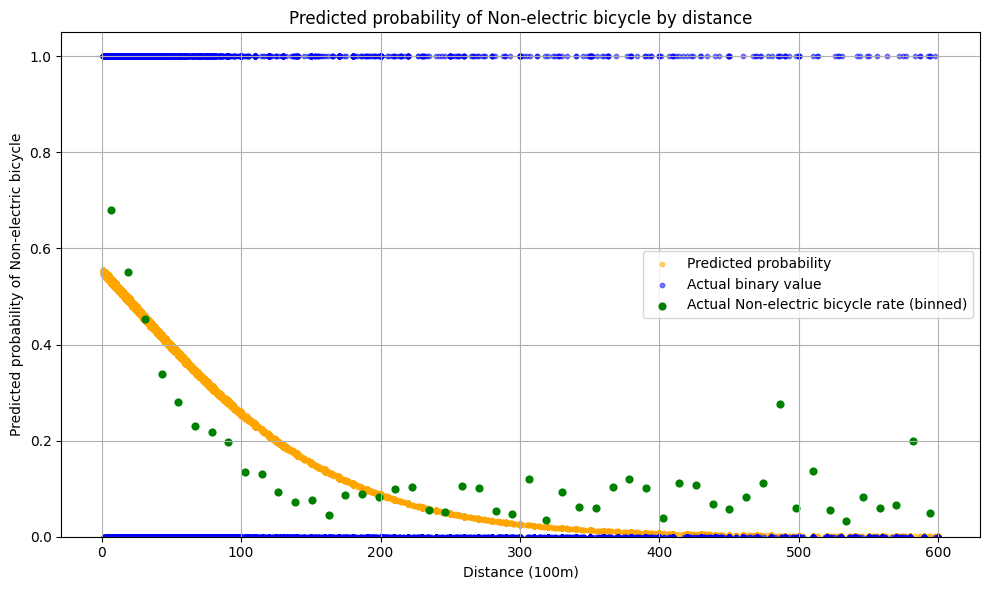

(Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('logisticregression', LogisticRegression())]),
 (                OPID  AfstV
  1       300000882980   10.0
  2       300000882980   10.0
  8       300000886980  170.0
  9       300000886980  170.0
  10      300000887980  110.0
  ...              ...    ...
  200036  309999882980  580.0
  200037  309999882980   30.0
  200038  309999882980  600.0
  200045  309999885980   12.0
  200046  309999885980   20.0
  
  [83332 rows x 2 columns],
                  OPID  AfstV
  15      300000981980  130.0
  16      300000981980  204.0
  18      300000981980  210.0
  19      300000981980  310.0
  20      300000981980  350.0
  ...              ...    ...
  200028  309999784980   40.0
  200048  309999888880  110.0
  200049  309999888880  110.0
  200052  309999888880   63.0
  200053  309999888880   63.0
  
  [21189 rows x 2 columns],
  15        False
  16        False
  18        False
  19        False
  20        False
            

In [14]:
# Include a subset af transport modes to compare the bike to

run_binary_regression(
        df_less_vehicles[df_less_vehicles[transport_mode_col].isin([1, 8,])],
        test_size=0.2,
        transport_modes_predict=[8, ],
        motives=motives,
        max_dist=max_dist,
        savename=f"graphics/classification_results/binary_regression/car_foot_and_bike/{transport_modes[transport_mode].replace(r'/', ' or ')}_{max_dist}",
    )